In [55]:
#Import functions and models to pass to those functions
import paths as p
import functions_model_testing as f
import os
import pickle
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [56]:
#If train mode is active we are training the features, if false we are using the features save it in the .pkl file
train_mode = True

In [57]:
#Create new folder to save the images without background
if os.path.isdir(p.new_path) == False:
    os.mkdir(p.new_path)

#Walk through the folder of the images and save it in the new folder without background
for folder, subfolders, filenames in os.walk(p.data_path):
    for img in filenames:
        if os.path.isfile(p.new_path + '/' + img) == False:
            image_path = folder + '/' + img
            remove_background(image_path, p.new_path)
        else:
            pass

In [58]:
#dict with models that are going to be tested and the image size they require as a tuple (model, size) (Different models may require different image sizes)
test_models = {
    "resnet50": (models.resnet50(pretrained=True), 224),
    'efficientnet_b0': (models.efficientnet_b0(pretrained=True), 224),
    "vgg16": (models.vgg16(pretrained=True), 224),
    #"googlenet": (models.googlenet(pretrained=True), 224),
}

In [59]:
#Create new folder to save the images without background
if os.path.isfile(p.dict_path + '/' + 'features_data.pkl') == False or train_mode == True:

    features = {}

    for model_name in test_models:
 
        model, size = test_models[model_name]
        model = f.get_encoder(model_name)
        features[model_name] = f.features_extraction(model, p.new_path, size=size)

    # save dictionary to person_data.pkl file
    with open(p.dict_path + '/' + 'features_data.pkl', 'wb') as fp:
        pickle.dump(features, fp)
        print('dictionary saved successfully to file')

else:
    # Read dictionary pkl file
    with open(p.dict_path + '/' + 'features_data.pkl', 'rb') as fp:
        features = pickle.load(fp)

dictionary saved successfully to file


In [60]:
#Create a dict with the features for each model and metric combination
sorted_sim_per_model = {}

for model_name in test_models:
    for metrics in ['cosine', 'euclidean', 'manhattan']:
 
        sorted_similarities = f.similarity_extraction(p.input_path, features[model_name], method=metrics)
        sorted_sim_per_model[model_name + '_' + metrics] = sorted_similarities

In [61]:
#Rank the best recommendations for each model
ranks = f.ranking_similarities(sorted_sim_per_model, top_n=10)

#Create a rank fusion of all individuals rankings
final_dict = f.reciprocal_rank_fusion(ranks)

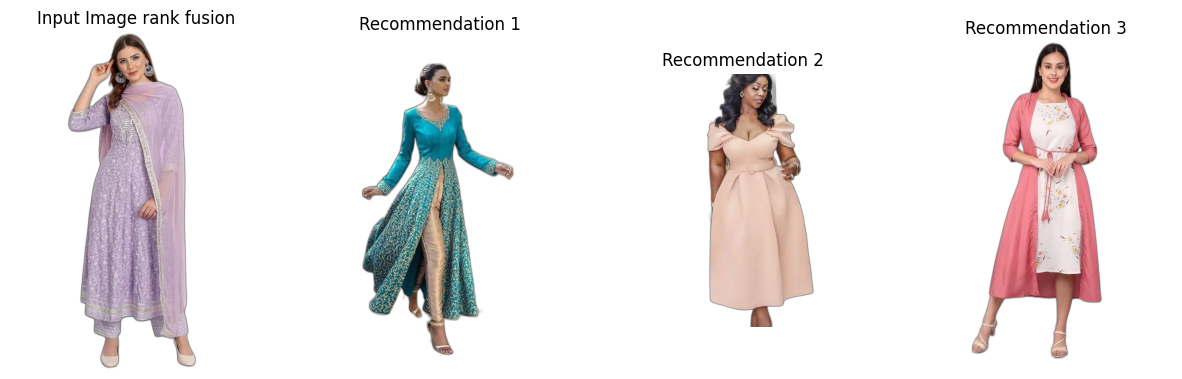

In [62]:
#Show the recommendations for this image
f.plot_recommendations(final_dict, p.input_path, model_name="rank fusion", top_n=3)